In [1]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
# %matplotlib notebook

import random
import gudhi as gd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.neighbors import KernelDensity
import numpy as np
from mma import *
from multipers import *

We first generate the data via noise over an anulus

In [2]:
def noisy_annulus(r1=1, r2=2, n=50):
    set =[]
    while len(set)<n:
        x,y=2*r2*random.random()-r2,2*r2*random.random()-r2
        if r1**2 < x**2 + y**2 < r2**2: 
            set += [[x,y]]
    return set

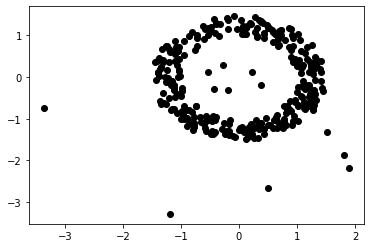

In [3]:
n_pts = 300
n_outliers = n_pts * 0.02
X = np.array(noisy_annulus(1,1.5,n_pts) + noisy_annulus(0,0.7,n_outliers) + noisy_annulus(1.7,4,n_outliers))
plt.scatter(X[:,0], X[:,1], c='black')
plt.show()

Then we compute an $\alpha$ complex filtration. As you can see, the usual $\alpha$ complex filtration doesn't detect any significant feature; we will add a density estimation to filter features by density to check if we can find the noisy circle.

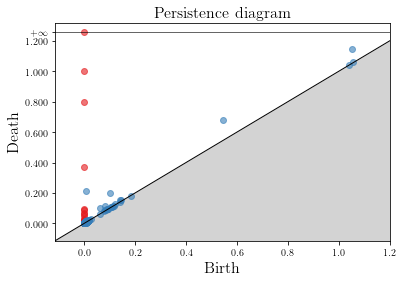

In [4]:
alpha_complex = gd.AlphaComplex(points=X)
simplex_tree = alpha_complex.create_simplex_tree(max_alpha_square=2)
simplex_tree.persistence()
dgm_alpha = simplex_tree.persistence_intervals_in_dimension(1)
gd.plot_persistence_diagram(simplex_tree.persistence())
plt.show()

We then compute an approximation of the density via a (gaussian) kernel density estimation (one can choose a simpler filtration to kill the outliers).

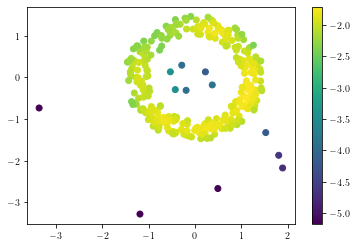

In [5]:
from sklearn.neighbors import KernelDensity

kde = KernelDensity(kernel='gaussian', bandwidth=.3).fit(X)
density = kde.score_samples(X)
plt.figure()
plt.scatter(X[:,0],X[:,1], c=density)
plt.colorbar()
plt.show()
# plt.savefig("circle+density.svg")

We then generate the boundary matrix and associated bifiltration with `ls_boundary_density`. We have to use this function because `filtration_density` is ordered with respect to the points (ie. is already ordered) and the simplices are ordered according to the order given by `Gudhi` (ie. is not ordered and has to be permuted, hence `to_permute = [0]`); this functions ensures that the filtrations and the boundary matrix have the same basis.

If available, this function will call `shapely` instead of `matplotlib` to plot the summands; it is useful when using the `alpha` parameter, as in the other case, it doesn't provide a correct output. 

Filtration dimension : 2
Number of simplices : 1815
Precision : 0.01
Number of lines : 499
Multithreading status : 0
Starting recursive vineyard loop... Done ! It took 0.08685 seconds.


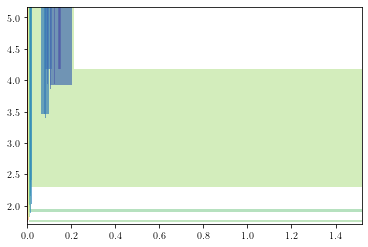

CPU times: user 410 ms, sys: 9.86 ms, total: 419 ms
Wall time: 417 ms


In [6]:
filtration_density = -np.array(density)
filtration_alpha = np.array([simplex_tree.filtration(s) for s,_ in simplex_tree.get_simplices()])
bifiltration = [filtration_alpha, filtration_density]
box = [[min(filtration_alpha),min(filtration_density)],[max(filtration_alpha),max(filtration_density)]]
precision=0.01
boundary, filters = ls_boundary_density(simplex_tree, bifiltration, to_permute=[0])
%time plot_approx_2d(boundary, filters,precision,box, dimension=1, separated=0, verbose=True, keep_order=1, min_interleaving =0, complete = 1, shapely=1, alpha = 0.7)

The vertical filtration corresponds to the density and the $\alpha$-complex filtration is the horizontal one. We can see here that we only have 1 signifiant interval summand; which corresponds to the noisy circle. One can use another density filtration such as k-nearest neighbors to have a smaller computational cost.